In [20]:
# ----------------------------------------------------
# 1. Imports & Setup
# ----------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import pickle
import warnings
warnings.filterwarnings("ignore")

# Download required NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

# Machine Learning & Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# For alternative model: XGBoost
from xgboost import XGBRegressor

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kaddo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kaddo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\kaddo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [21]:
# ----------------------------------------------------
# 2. Define Synonym Replacement Function with Expanded Dictionary
# ----------------------------------------------------
synonyms = {
    'apples': 'apple',
    'bananas': 'banana',
    'tomatoes': 'tomato',
    'strawberries': 'strawberry',
    'blueberries': 'blueberry',
    'oranges': 'orange',
    'potatoes': 'potato',
    'carrots': 'carrot',
    'broccolis': 'broccoli',
    'grapes': 'grape',
    'peaches': 'peach',
    'mangoes': 'mango',
    'pineapples': 'pineapple',
    'watermelons': 'watermelon',
    'lemons': 'lemon',
    'limes': 'lime',
    'cherries': 'cherry',
    'pears': 'pear',
    'avocados': 'avocado',
    'cucumbers': 'cucumber',
    'bell peppers': 'pepper',
    'peppers': 'pepper',
    'mushrooms': 'mushroom',
    'zucchinis': 'zucchini',
    'onions': 'onion',
    'garlics': 'garlic',
    'eggs': 'egg',
    'breads': 'bread',
    'pizzas': 'pizza',
    'burgers': 'burger',
    'sandwiches': 'sandwich',
    'cookies': 'cookie',
    'cakes': 'cake',
    'pies': 'pie',
    'lettuces': 'lettuce',
    'cabbages': 'cabbage',
    'celeries': 'celery',
    'sausages': 'sausage',
    'steaks': 'steak',
    'noodles': 'noodle',
    'beans': 'bean',
    'lentils': 'lentil',
    'oats': 'oat',
    'cereals': 'cereal',
    'cheeses': 'cheese',
    'yogurts': 'yogurt',
    'butters': 'butter',
    'salads': 'salad',
    'soups': 'soup',
    'stews': 'stew',
    'chicken breasts': 'chicken breast',
    'chicken legs': 'chicken leg',
    'pork chops': 'pork chop',
    'beef steaks': 'beef steak'
}

def replace_synonyms(text, synonyms_dict):
    """
    Replace words in text based on a synonyms dictionary.
    """
    for word, replacement in synonyms_dict.items():
        text = re.sub(r'\b' + re.escape(word) + r'\b', replacement, text)
    return text

In [22]:
# ----------------------------------------------------
# 3. Custom Text Preprocessing Function with Lemmatization & Synonym Replacement
# ----------------------------------------------------
def lemmatize_text(text):
    """
    Convert text to lowercase, replace synonyms, remove punctuation,
    tokenize, and lemmatize.
    """
    text = text.lower()
    text = replace_synonyms(text, synonyms)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    tokens = nltk.word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    lem_tokens = [lemmatizer.lemmatize(tok) for tok in tokens]
    return ' '.join(lem_tokens)

In [23]:
# ----------------------------------------------------
# 4. Data Acquisition, Initial Cleaning, and Feature Engineering
# ----------------------------------------------------
df = pd.read_csv(r"C:\Users\kaddo\Desktop\nutrition project\Dataset\nutrients_csvfile.csv")

print("First few rows:")
print(df.head())
print("\nDataFrame info:")
print(df.info())
print("\nColumn names:", df.columns.tolist())
print("\nMissing values per column:")
print(df.isnull().sum())

# Drop duplicate rows
df.drop_duplicates(inplace=True)

# Normalize textual columns
df['Food'] = df['Food'].str.lower().str.strip()
df['Measure'] = df['Measure'].str.lower().str.strip()
df['Category'] = df['Category'].str.strip()

# Convert 'Grams' to numeric (removing any commas if necessary)
df['Grams'] = pd.to_numeric(df['Grams'].str.replace(',', ''), errors='coerce')

# Create a new combined text feature 'description'
df['description'] = df['Food'] + " " + df['Category'] + " " + df['Measure']

# Create additional numeric feature
df['name_length'] = df['Food'].apply(len)

First few rows:
                    Food Measure  Grams Calories Protein Fat Sat.Fat Fiber  \
0             Cows' milk   1 qt.    976      660      32  40      36     0   
1              Milk skim   1 qt.    984      360      36   t       t     0   
2             Buttermilk   1 cup    246      127       9   5       4     0   
3  Evaporated, undiluted   1 cup    252      345      16  20      18     0   
4         Fortified milk  6 cups  1,419    1,373      89  42      23   1.4   

  Carbs        Category  
0    48  Dairy products  
1    52  Dairy products  
2    13  Dairy products  
3    24  Dairy products  
4   119  Dairy products  

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335 entries, 0 to 334
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Food      335 non-null    object
 1   Measure   335 non-null    object
 2   Grams     335 non-null    object
 3   Calories  334 non-null    object
 4   Prot

In [24]:
# ----------------------------------------------------
# 5. Handle "t"/"T" and Convert to Numeric for Nutrient Columns
# ----------------------------------------------------
numeric_cols = ['Calories', 'Protein', 'Fat', 'Carbs']

for col in numeric_cols:
    df[col] = df[col].astype(str).str.replace(',', '', regex=False).str.strip()
    # Replace 't' or 'T' with NaN to impute trace amounts
    df[col] = df[col].replace(['t', 'T'], np.nan)
    df[col] = pd.to_numeric(df[col], errors='coerce')
    median_val = df[col].median()
    if col == 'Fat' and median_val == 0:
        df[col].fillna(0.1, inplace=True)
    else:
        df[col].fillna(median_val, inplace=True)

print("\nMissing values in numeric columns after cleaning:")
print(df[numeric_cols].isnull().sum())
print("\nDataFrame shape after cleaning:", df.shape)


Missing values in numeric columns after cleaning:
Calories    0
Protein     0
Fat         0
Carbs       0
dtype: int64

DataFrame shape after cleaning: (335, 12)


In [25]:
# ----------------------------------------------------
# 6. Feature Engineering
# ----------------------------------------------------
df['name_length'] = df['Food'].apply(len)

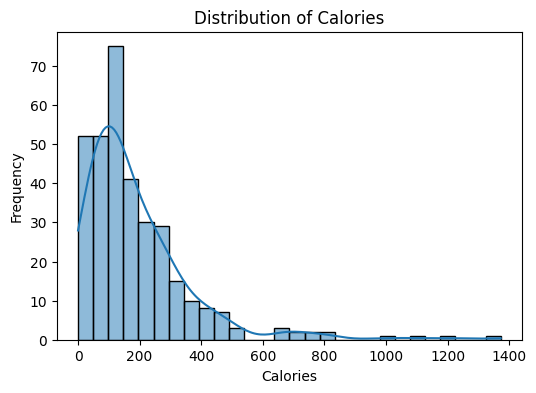

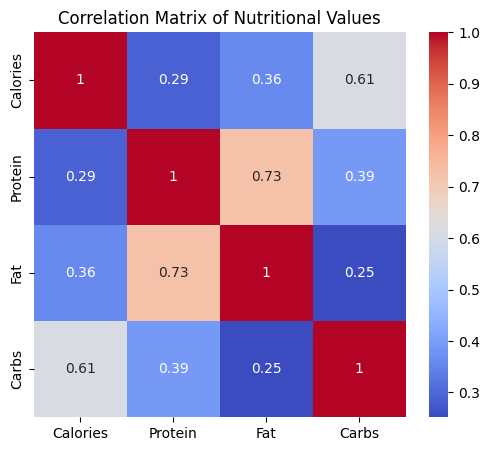

In [26]:
# ----------------------------------------------------
# 7. Exploratory Data Analysis (Optional)
# ----------------------------------------------------
plt.figure(figsize=(6, 4))
sns.histplot(df['Calories'], kde=True)
plt.title('Distribution of Calories')
plt.xlabel('Calories')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(6, 5))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Nutritional Values')
plt.show()

In [27]:
# ----------------------------------------------------
# 8. Train-Test Split using the enriched features
# ----------------------------------------------------
# Now we use the 'description' column plus numeric features.
feature_cols = ['description', 'name_length', 'Grams']
X = df[feature_cols]
y = df[numeric_cols]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("\nTraining set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])



Training set size: 268
Testing set size: 67


In [28]:
# ----------------------------------------------------
# 9. Building a ColumnTransformer with the Enriched Features
# ----------------------------------------------------
# Text transformer for 'description'
text_transformer = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=lemmatize_text))
])

# Numeric transformer for 'name_length' and 'Grams'
num_transformer = Pipeline([
    ('scale', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('text', text_transformer, 'description'),
    ('num', num_transformer, ['name_length', 'Grams'])
])

In [29]:
# ----------------------------------------------------
# 10. Build the Full Pipeline with RandomForestRegressor
# ----------------------------------------------------
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', MultiOutputRegressor(RandomForestRegressor(random_state=42)))
])

In [30]:
# ----------------------------------------------------
# 11. Expanded Hyperparameter Tuning with GridSearchCV
# ----------------------------------------------------

param_grid_rf = {
    'preprocessor__text__tfidf__max_features': [300, 500, 1000],
    'regressor__estimator__n_estimators': [100, 200, 300],
    'regressor__estimator__max_depth': [None, 10, 20],
    'regressor__estimator__min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(
    pipeline_rf,
    param_grid_rf,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

grid_search_rf.fit(X_train, y_train)
print("\nBest parameters (RandomForest):", grid_search_rf.best_params_)
best_model_rf = grid_search_rf.best_estimator_


Best parameters (RandomForest): {'preprocessor__text__tfidf__max_features': 300, 'regressor__estimator__max_depth': None, 'regressor__estimator__min_samples_split': 2, 'regressor__estimator__n_estimators': 300}


In [31]:
# ----------------------------------------------------
# 12. Alternative Model Pipeline with XGBoost (Expanded Hyperparameters)
# ----------------------------------------------------
pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', MultiOutputRegressor(XGBRegressor(random_state=42, objective='reg:squarederror')))
])

param_grid_xgb = {
    'preprocessor__text__tfidf__max_features': [300, 500, 1000],
    'regressor__estimator__n_estimators': [100, 200, 300],
    'regressor__estimator__max_depth': [3, 6, 10],
    'regressor__estimator__learning_rate': [0.01, 0.1, 0.2]
}

grid_search_xgb = GridSearchCV(
    pipeline_xgb,
    param_grid_xgb,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

grid_search_xgb.fit(X_train, y_train)
print("\nBest parameters (XGBoost):", grid_search_xgb.best_params_)
best_model_xgb = grid_search_xgb.best_estimator_


Best parameters (XGBoost): {'preprocessor__text__tfidf__max_features': 300, 'regressor__estimator__learning_rate': 0.01, 'regressor__estimator__max_depth': 6, 'regressor__estimator__n_estimators': 300}



Overall Mean Absolute Error (MAE): 22.9281604477612
Overall Mean Squared Error (MSE): 3867.0643171770316

--- Calories ---
MAE: 65.80
MSE: 13068.99
R² : 0.473

--- Protein ---
MAE: 6.50
MSE: 697.06
R² : 0.143

--- Fat ---
MAE: 8.29
MSE: 891.48
R² : 0.062

--- Carbs ---
MAE: 11.13
MSE: 810.73
R² : 0.211


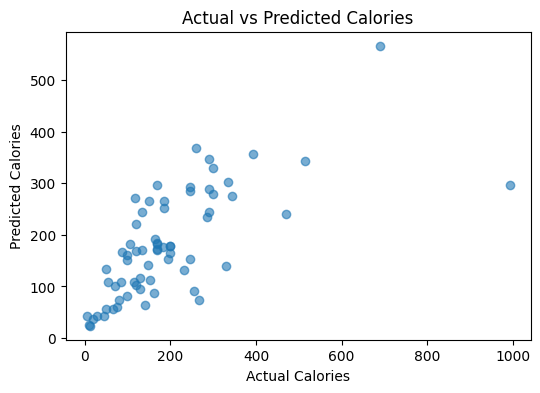

In [32]:
# ----------------------------------------------------
# 13. Model Evaluation for the Selected Model (Using the best performing model)
# ----------------------------------------------------
# Here you may choose the best model based on cross-validation metrics.
# For example, you can compare RF vs. XGB on a hold-out set.
# Below we evaluate the RandomForest-based model.
y_pred = best_model_rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("\nOverall Mean Absolute Error (MAE):", mae)
print("Overall Mean Squared Error (MSE):", mse)

for i, col in enumerate(numeric_cols):
    col_mae = mean_absolute_error(y_test[col], y_pred[:, i])
    col_mse = mean_squared_error(y_test[col], y_pred[:, i])
    col_r2  = r2_score(y_test[col], y_pred[:, i])
    print(f"\n--- {col} ---")
    print(f"MAE: {col_mae:.2f}")
    print(f"MSE: {col_mse:.2f}")
    print(f"R² : {col_r2:.3f}")

plt.figure(figsize=(6, 4))
plt.scatter(y_test['Calories'], y_pred[:, 0], alpha=0.6)
plt.xlabel("Actual Calories")
plt.ylabel("Predicted Calories")
plt.title("Actual vs Predicted Calories")
plt.show()

In [33]:
# ----------------------------------------------------
# 14. Save and Load the Model
# ----------------------------------------------------
with open('nutrition_model.pkl', 'wb') as f:
    pickle.dump(best_model_rf, f)

with open('nutrition_model_rf.pkl', 'rb') as f:
    loaded_model = pickle.load(f)


In [34]:
# ----------------------------------------------------
# 15. Single Prediction Function (Updated for Enriched Features)
# ----------------------------------------------------
def predict_nutrition(product_name, category, measure, grams, model):
    """
    Predict the nutritional values for a given product using enriched features.
    The new 'description' field is built from Food, Category, and Measure.
    """
    description = f"{product_name.lower().strip()} {category.strip()} {measure.lower().strip()}"
    row = pd.DataFrame({
        'description': [description],
        'name_length': [len(product_name)],
        'Grams': [grams]
    })
    preds = model.predict(row)
    return dict(zip(numeric_cols, preds[0]))

# Test with a single input
test_food = "apple"
test_category = "Fruits"    # Ensure this category overlaps with training data.
test_measure = "1 medium"    # Example measure.
test_grams = 182             # Example grams for a medium apple.
result = predict_nutrition(test_food, test_category, test_measure, test_grams, best_model_rf)
print(f"\nPredicted nutritional values for '{test_food}': {result}")

# Testing with multiple inputs
test_samples = [
    {"Food": "banana", "Category": "Fruits", "Measure": "1 medium", "Grams": 118},
    {"Food": "chicken breast", "Category": "Meat", "Measure": "1 piece", "Grams": 120},
    {"Food": "broccoli", "Category": "Vegetables", "Measure": "1 cup", "Grams": 91}
]

for sample in test_samples:
    nutrition = predict_nutrition(sample["Food"], sample["Category"],
                                  sample["Measure"], sample["Grams"], best_model_rf)
    print(f"Product: {sample['Food']} -> Nutrition: {nutrition}")


Predicted nutritional values for 'apple': {'Calories': 102.02666666666667, 'Protein': 2.4466666666666668, 'Fat': 6.3966666666666665, 'Carbs': 40.36}
Product: banana -> Nutrition: {'Calories': 82.1, 'Protein': 2.466666666666667, 'Fat': 7.88, 'Carbs': 19.836666666666666}
Product: chicken breast -> Nutrition: {'Calories': 304.8933333333333, 'Protein': 14.78, 'Fat': 8.57, 'Carbs': 7.621333333333332}
Product: broccoli -> Nutrition: {'Calories': 30.69, 'Protein': 2.8633333333333333, 'Fat': 6.05, 'Carbs': 7.207666666666667}
